In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
print(f"Old working dir {os.getcwd()}")
os.chdir('../../')
print(f"New working dir {os.getcwd()}")

Old working dir /home/alex/repos/conditional_quantile_function/notebooks/conformal
New working dir /home/alex/repos/conditional_quantile_function


In [29]:
from pathlib import Path
plots_dir = Path('./conformal_plots/')
os.makedirs(plots_dir, exist_ok=True)

In [3]:
from pathlib import Path

import numpy as np
import pandas as pd
import torch

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
results_dir = Path('./conformal_results_u/')
#results_dir = Path('./conformal_results/')

In [5]:
from conformal.real_datasets.process_raw import datasets

In [6]:
n_targets = {"rf1": 8, "rf2": 8, "scm1d": 16, "scm20d": 16, "sgemm": 4, "bio": 2, "blog": 2}
df_n_targets = pd.DataFrame({"dataset_name": n_targets.keys(), "n_targets": n_targets.values()})
df_n_targets

,dataset_name,n_targets
0,rf1,8
1,rf2,8
2,scm1d,16
3,scm20d,16
4,sgemm,4
5,bio,2
6,blog,2


In [7]:
palette = {
    "OT-CP-Global": "#204dca",
    "OT-CP-Local": "#3D4E88",
    "Ell-Local": "#62879C",
    "PB": "#54c229",
    "RPB": "#316431",
    "HPD": "#738356",
    "Quantile": "#85e9b7",
    "PB (CPFlow)": "#ecb00b",
    "RPB (CPFlow)": "#ff7f0e",
    "HPD (CPFlow)": "#fffb01",
    "Quantile (CPFlow)": "#ccd69f",}

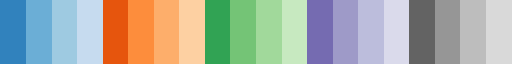

In [8]:
t20c = matplotlib.colormaps["tab20c"]
t20c

In [ ]:
palette = {
    "OT-CP-Global": t20c(0),
    "OT-CP-Local": t20c(1),
    "Ell-Local": t20c(2),
    "PB": t20c(4),
    "RPB": t20c(5),
    "HPD": t20c(6),
    "Quantile": t20c(7),
    "PB (CPFlow)": t20c(8),
    "RPB (CPFlow)": t20c(9),
    "HPD (CPFlow)": t20c(10),
    "Quantile (CPFlow)": t20c(11),
    "PB (Y)": t20c(13),
    "RPB (Y)": t20c(14),
    "HPD (Y)": t20c(15),
    "Quantile (Y)": t20c(16),
}

In [10]:
import seaborn as sns
import numpy as np

def blended_palette(colA, colB, paletteA="Set1", paletteB="Set2", alpha=0.5):
    """
    Generate a color palette for objects described by two categorical columns.
    Objects that share values in colA or colB will get 'similar' colors.
    
    Parameters
    ----------
    colA : list-like
        First categorical column
    colB : list-like
        Second categorical column
    paletteA : str or list, default="Set1"
        Base palette for colA categories (Seaborn palette name or list of colors)
    paletteB : str or list, default="Set2"
        Base palette for colB categories (Seaborn palette name or list of colors)
    alpha : float in [0,1], default=0.5
        Blend factor. alpha=0 → only colB matters, alpha=1 → only colA matters.
    
    Returns
    -------
    dict
        Mapping from (colA, colB) pairs → blended RGB colors
    """
    
    # Unique categories
    uniqA = pd.Series(colA).unique()
    uniqB = pd.Series(colB).unique()
    
    # Build base palettes
    palA = sns.color_palette(paletteA, len(uniqA))
    palB = sns.color_palette(paletteB, len(uniqB))
    
    mapA = dict(zip(uniqA, palA))
    mapB = dict(zip(uniqB, palB))
    
    # Blending function
    def blend(c1, c2):
        return tuple(np.array(c1)*alpha + np.array(c2)*(1-alpha))
    
    # Map pairs to colors
    return {
        (a, b): blend(mapA[a], mapB[b])
        for a, b in zip(colA, colB)
    }


In [11]:
dataframes = []
seeds = range(10)
for seed in seeds:
    for dataset_name in datasets:
        fn = results_dir / dataset_name / str(seed) / f"metrics_all.feather"
        if fn.is_file():
            dataframes.append(pd.read_feather(fn))
        else:
            print(f"Error: dataset {dataset_name}, seed {seed} not found.")
df = pd.concat(dataframes).merge(df_n_targets, on="dataset_name")
df["log_vol_d"] = np.log(df["volume"]) / df["n_targets"]
df.head()

Error: dataset rf1, seed 0 not found.
Error: dataset rf2, seed 0 not found.
Error: dataset scm1d, seed 0 not found.
Error: dataset scm20d, seed 0 not found.
Error: dataset rf1, seed 1 not found.
Error: dataset rf2, seed 1 not found.
Error: dataset scm1d, seed 1 not found.
Error: dataset scm20d, seed 1 not found.
Error: dataset rf1, seed 2 not found.
Error: dataset rf2, seed 2 not found.
Error: dataset scm1d, seed 2 not found.
Error: dataset scm20d, seed 2 not found.
Error: dataset rf1, seed 3 not found.
Error: dataset rf2, seed 3 not found.
Error: dataset scm1d, seed 3 not found.
Error: dataset scm20d, seed 3 not found.
Error: dataset rf1, seed 4 not found.
Error: dataset rf2, seed 4 not found.
Error: dataset scm1d, seed 4 not found.
Error: dataset scm20d, seed 4 not found.
Error: dataset rf1, seed 5 not found.
Error: dataset rf2, seed 5 not found.
Error: dataset scm1d, seed 5 not found.
Error: dataset scm20d, seed 5 not found.
Error: dataset rf1, seed 6 not found.
Error: dataset rf2, 

/home/alex/repos/conditional_quantile_function/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,dataset_name,seed,method_name,method_name_mathtext,score_name,conformalizer,base_model_name,alpha,marginal_coverage,worst_slab_coverage,volume,n_targets,log_vol_d
0,sgemm,0,OT-CP-Global,$\mathrm{OT}$-$\mathrm{CP}$,Signed Error,OTCPGlobalPredictor,RandomForest,0.1,0.9090,0.766082,1.193800e+02,4,1.195578
1,sgemm,0,OT-CP-Local,$\mathrm{OT}$-$\mathrm{CP}$+,Signed Error,OTCPLocalPredictor,RandomForest,0.1,0.9150,0.911290,7.024937e-05,4,-2.390865
2,sgemm,0,Ell-Local,$\mathrm{ELL}$-$\mathrm{local}$+,Signed Error,EllipsoidalLocal,RandomForest,0.1,0.9065,0.778481,1.190978e-08,4,-4.561476
3,sgemm,0,PB,$\mathcal{C}^{\mathrm{pb}}$,MK Rank,SplitConformalPredictor,CVQRegressor,0.1,0.9115,0.922619,3.426562e-04,4,-1.994696
4,sgemm,0,RPB,$\mathcal{C}^{\mathrm{rpb}}$,MK Quantile,OTCPGlobalPredictor,CVQRegressor,0.1,0.9065,0.891566,9.736370e+01,4,1.144613


In [12]:
#df.head(20)

In [13]:
df["dataset_name"].unique(), df["n_targets"].unique()

(array(['sgemm', 'bio', 'blog'], dtype=object), array([4, 2]))

In [14]:
#palette = blended_palette(df["base_model_name"], df["conformalizer"], paletteA="Set1", paletteB="Set2")

In [15]:
#pd.DataFrame.from_dict(palette, orient="index")

In [16]:
df["method_name"].unique()

array(['OT-CP-Global', 'OT-CP-Local', 'Ell-Local', 'PB', 'RPB', 'HPD',
       'Quantile', 'PB (CPFlow)', 'RPB (CPFlow)', 'HPD (CPFlow)',
       'Quantile (CPFlow)'], dtype=object)

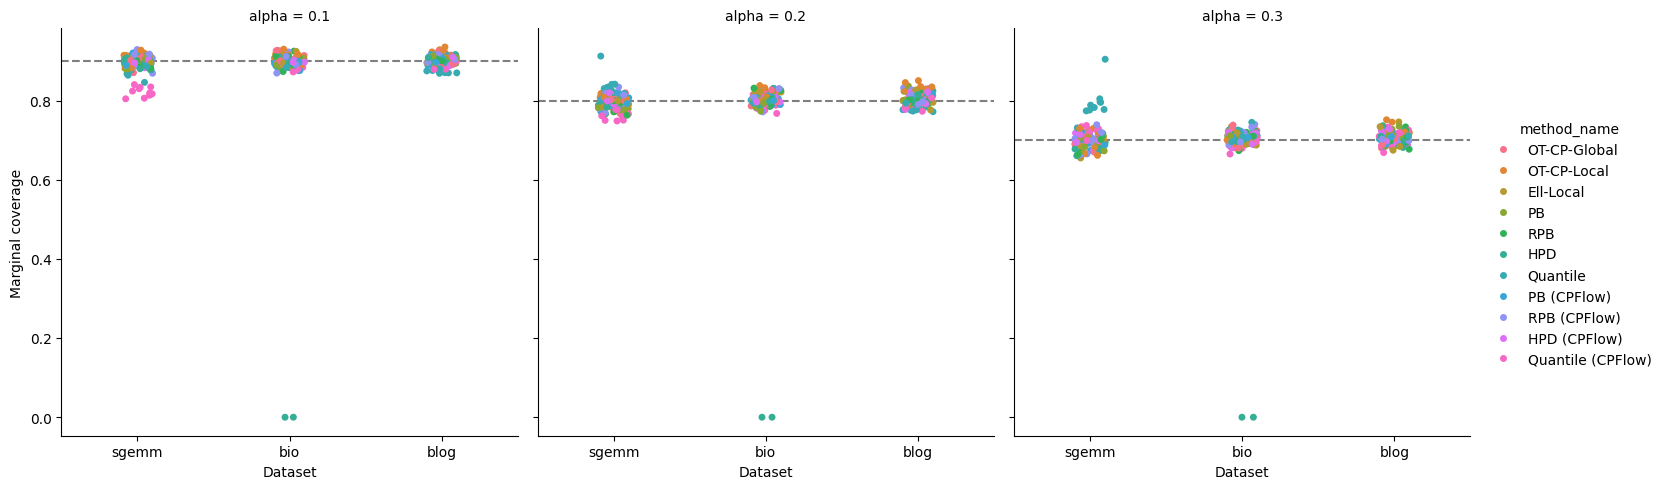

In [17]:
g_cov = sns.catplot(
    data=df, x="dataset_name", y="marginal_coverage", col="alpha", hue="method_name"
)
g_cov.set_axis_labels("Dataset", "Marginal coverage")
for alpha, ax in g_cov.axes_dict.items():
    ax.axhline(1 - alpha, ls="--", c="k", alpha=0.5)
for ax in g_cov.axes.flatten():
    ax.tick_params(labelbottom=True)

In [18]:
#g_cov.axes_dict

In [19]:
#df

In [20]:
metrics_columns = ["marginal_coverage", "worst_slab_coverage", "volume", "log_vol_d"]
id_vars = list(df.columns.difference(metrics_columns))
df_melted = pd.melt(df, id_vars=id_vars, value_vars=metrics_columns, var_name="metric", value_name="value")

In [21]:
len(df_melted)

3960

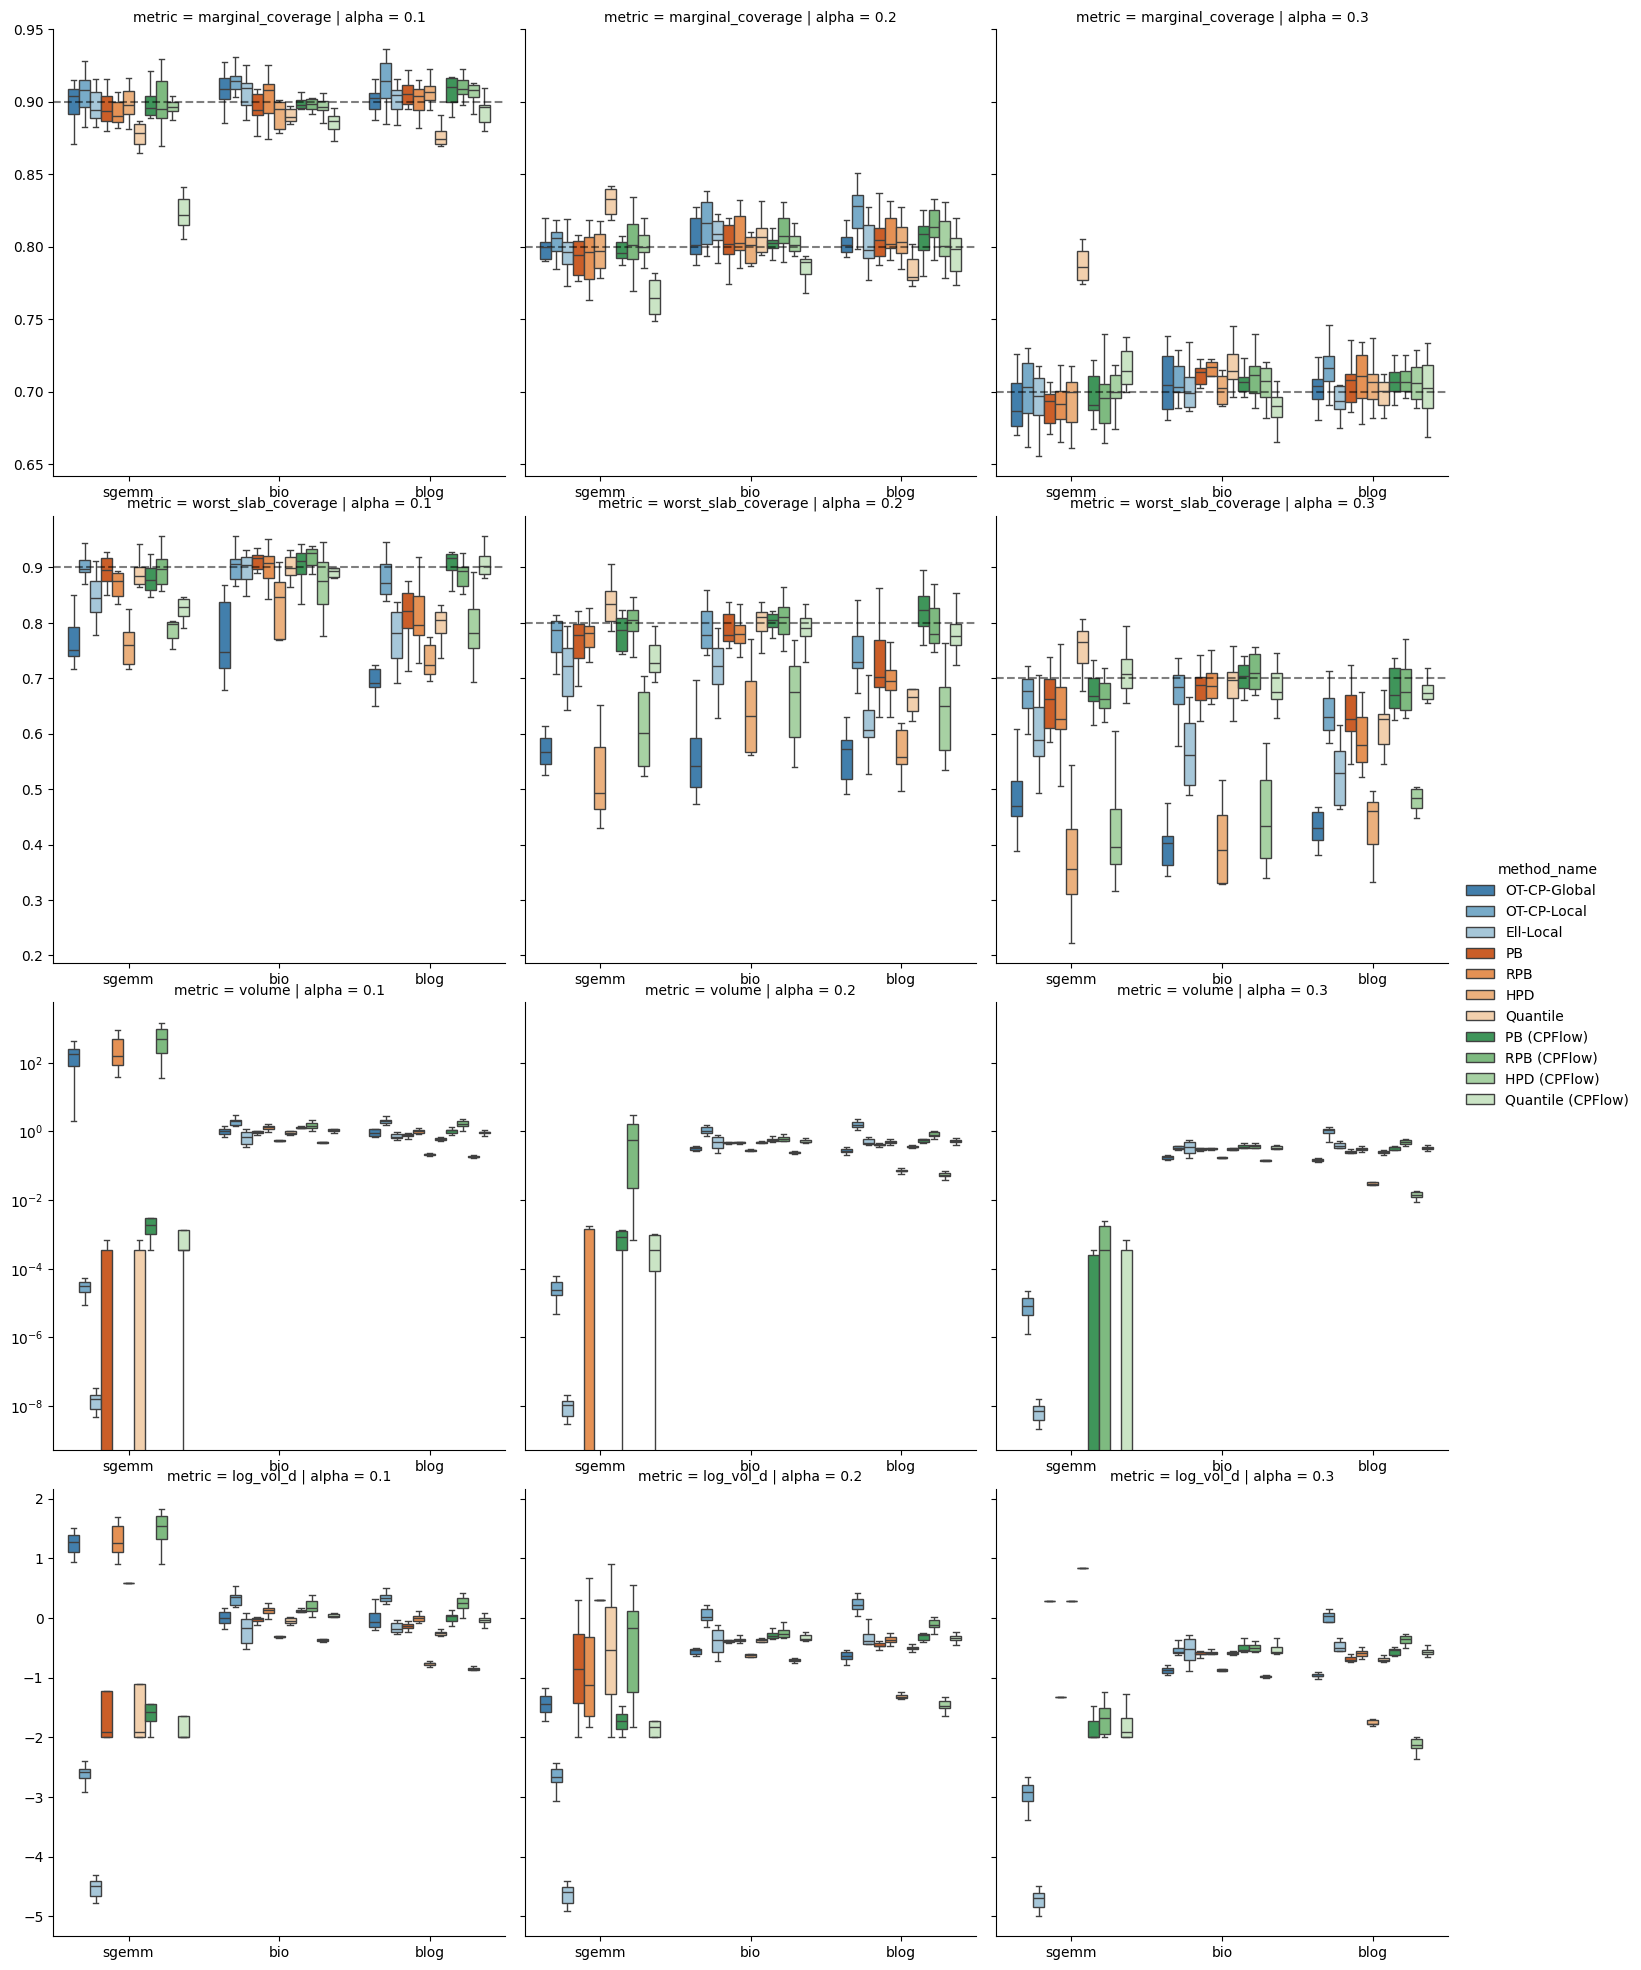

In [22]:
g_all = sns.catplot(
    data=df_melted,#.query("dataset_name == 'bio' or dataset_name == 'blog'"), 
    kind="box", 
    x="dataset_name", y="value", col="alpha", row="metric", hue="method_name", #_mathtext",
    palette=palette,
    sharey="row", showfliers=False,
)
g_all.set_axis_labels("", "")
for (metric_name, alpha), ax in g_all.axes_dict.items():
    if "coverage" in metric_name:
        ax.axhline(1 - alpha, ls="--", c="k", alpha=0.5)
    if "volume" in metric_name:
        ax.set_yscale("log")
for ax in g_all.axes.flatten():
    ax.tick_params(labelbottom=True)

In [23]:
#g_all.axes_dict

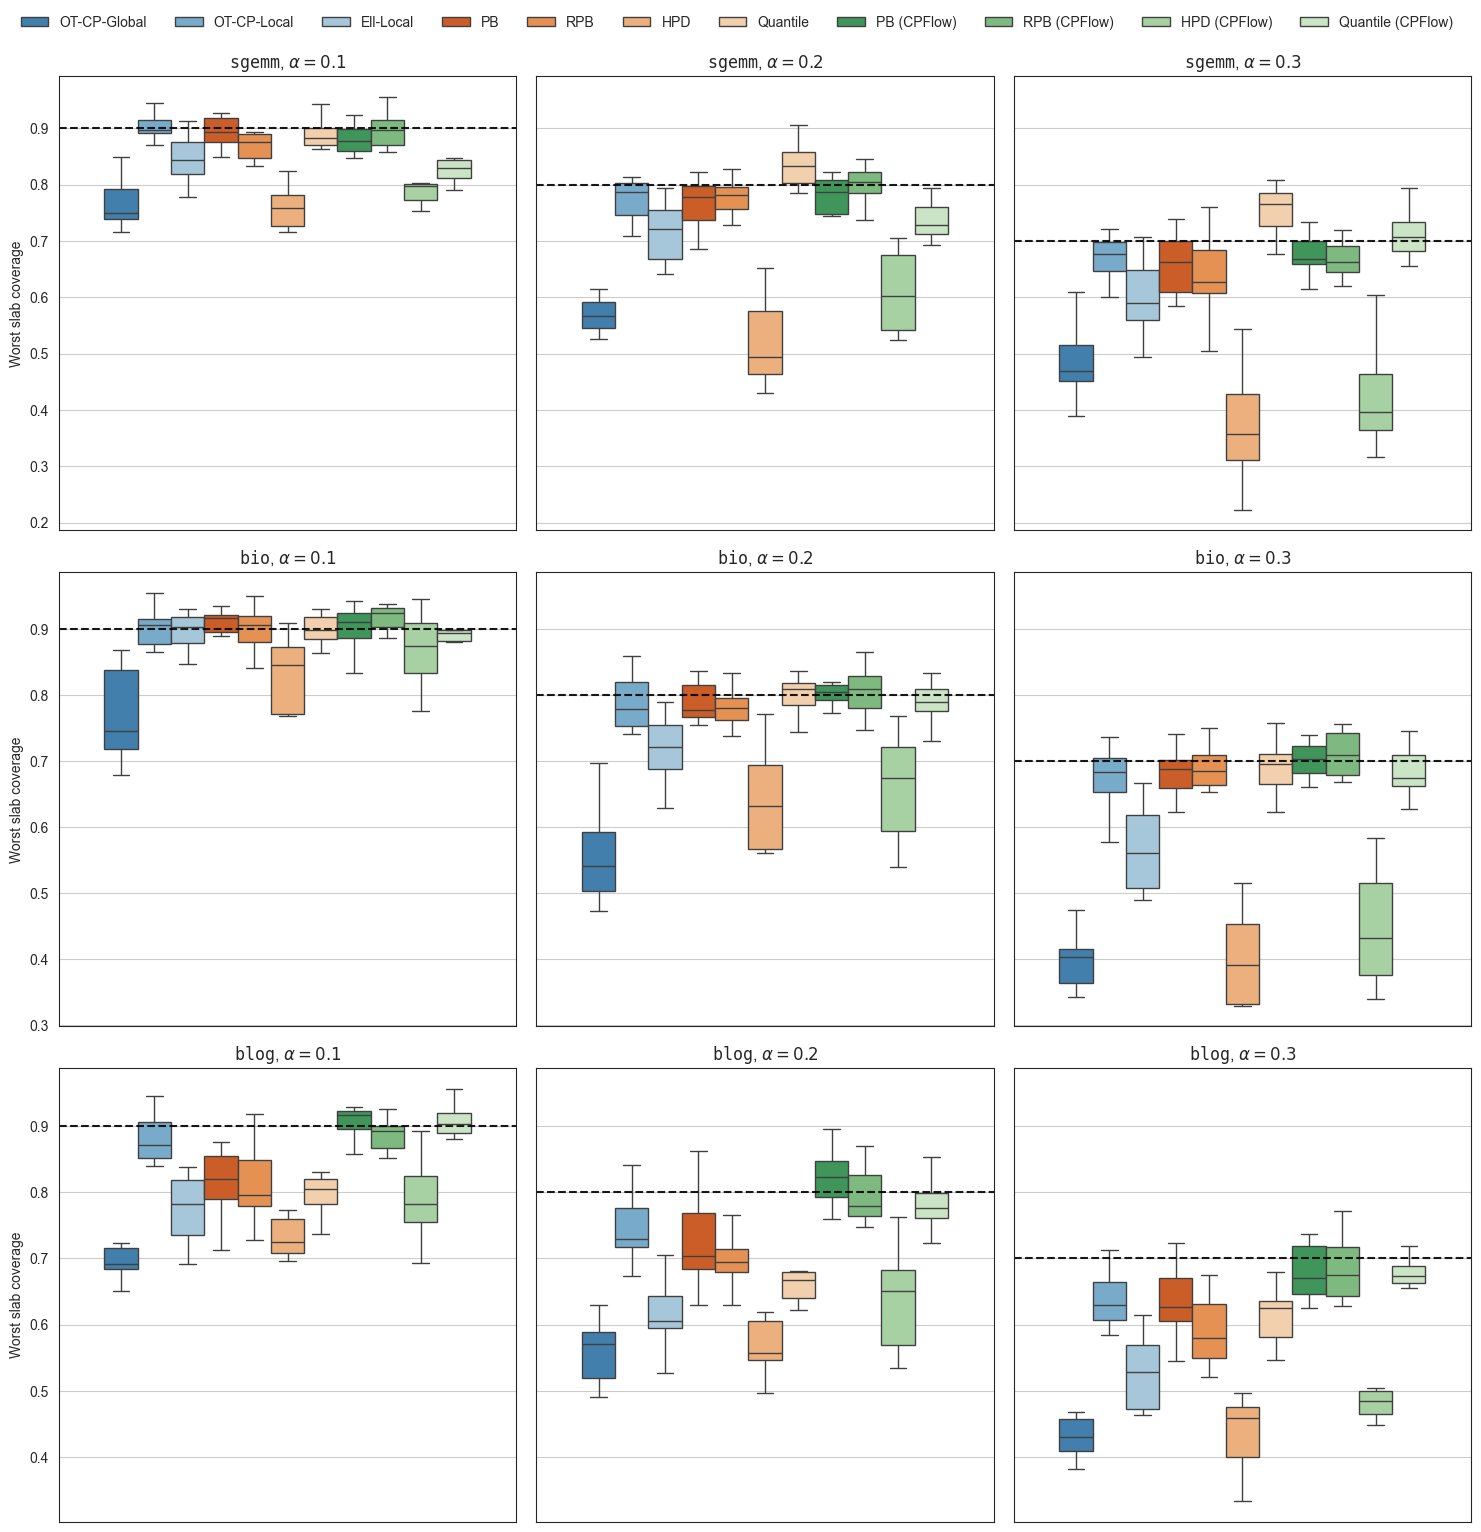

In [68]:
sns.set_style({'axes.grid' : True})
g_wsc = sns.catplot(
    data=df,#.query("dataset_name == 'bio' or dataset_name == 'blog'"),
    kind="box",
    y="worst_slab_coverage",
    col="alpha",
    row="dataset_name",
    hue="method_name", #_mathtext",
    palette=palette,
    sharey="row",
    showfliers=False,
)
sns.move_legend(g_wsc, "lower center", bbox_to_anchor=(0.45, 1), ncol=len(palette), title=None)
g_wsc.set_axis_labels("", "Worst slab coverage")
g_wsc.set_xticklabels([])
g_wsc.despine(bottom=False, top=False, right=False)
for (dataset_name, alpha,), ax in g_wsc.axes_dict.items():
    ax.set_title(rf"$\mathtt{{{dataset_name}}}$, $\alpha={alpha:.1f}$")
    ax.axhline(1 - alpha, xmax=1, ls="--", c="k", alpha=0.9)
for ax in g_wsc.axes.flatten():
    ax.tick_params(left=False, bottom=False)

g_wsc.savefig(plots_dir / "big_data_worst_slab_coverage_250920.pdf", bbox_inches="tight")
g_wsc.savefig(plots_dir / "big_data_worst_slab_coverage_250920.png", bbox_inches="tight")

In [25]:
#list(g_wsc.axes_dict.items())[0]

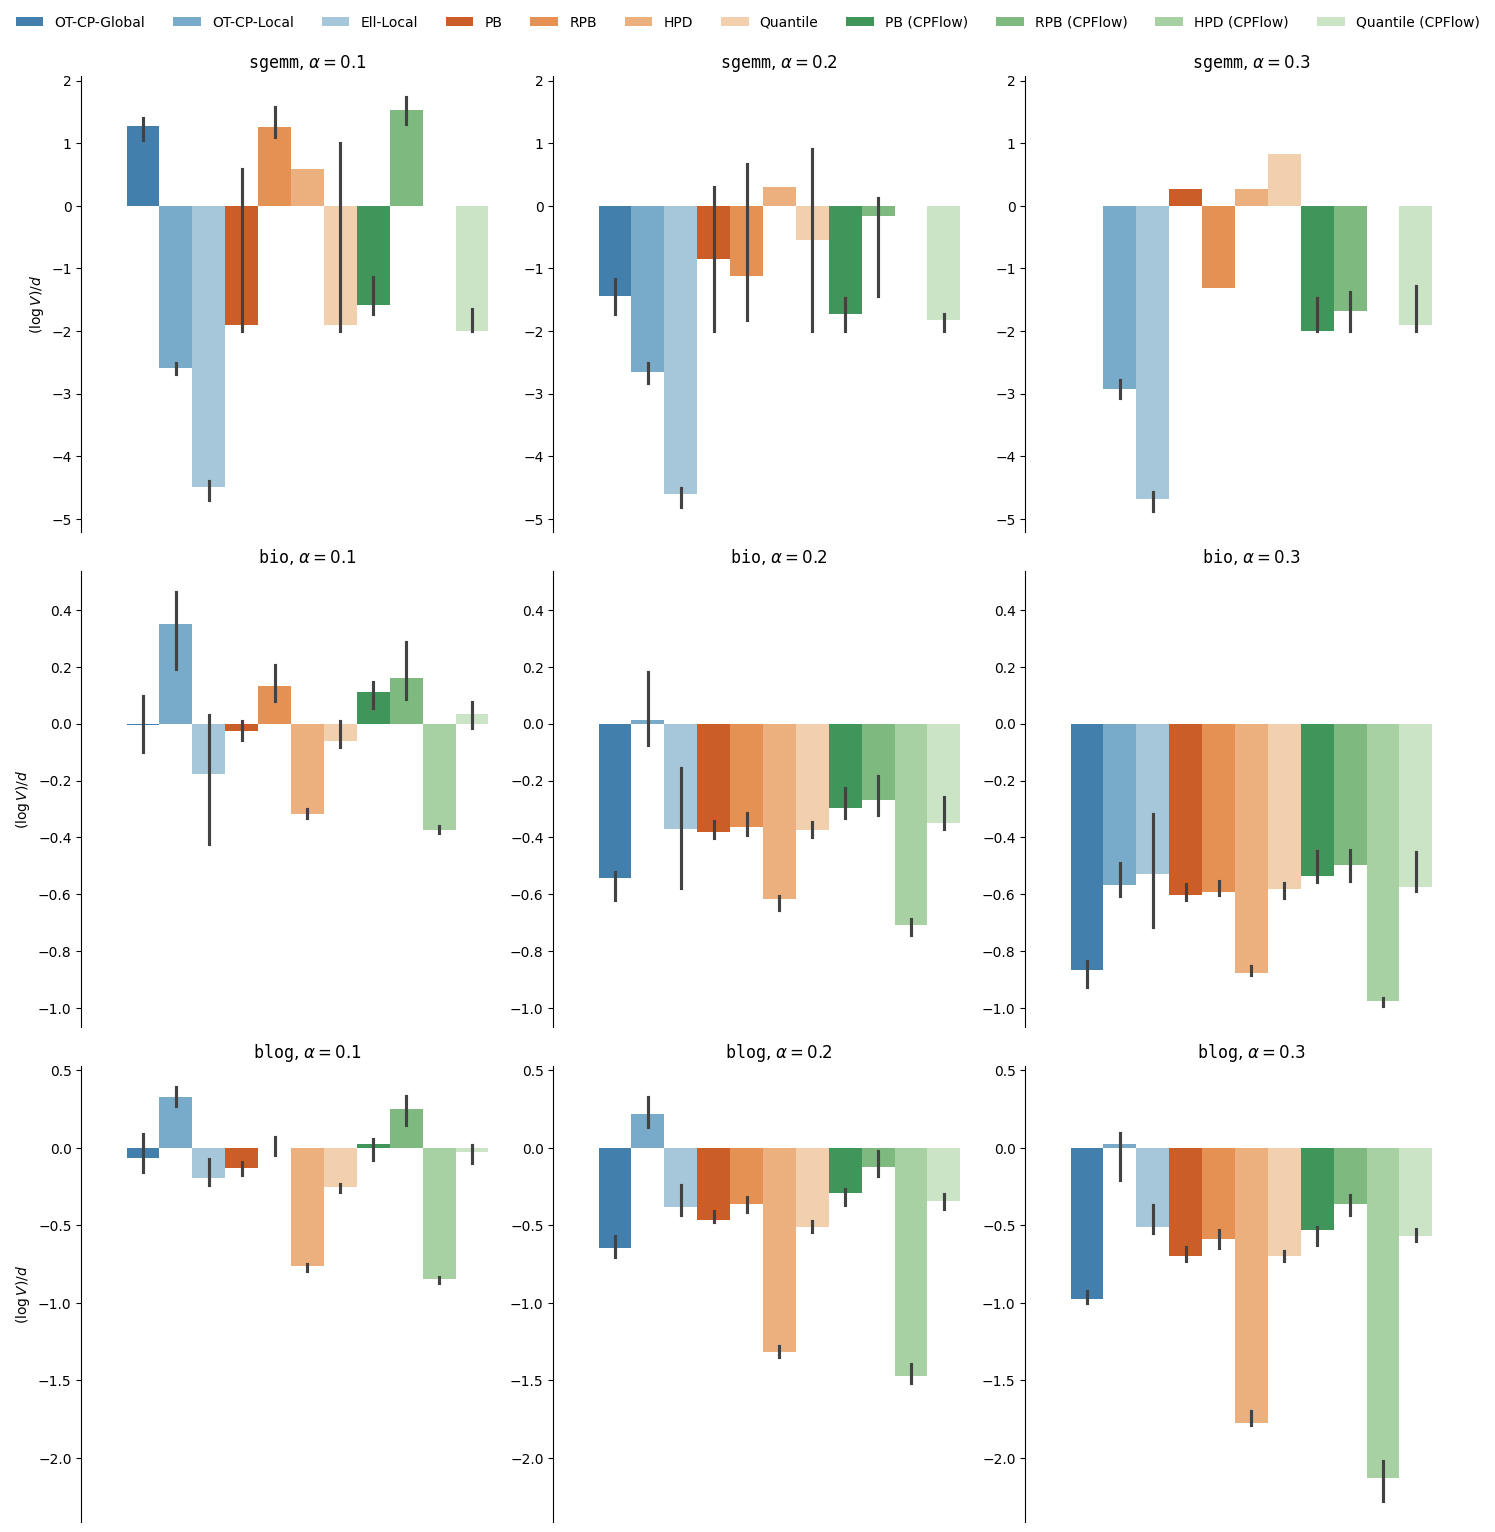

In [60]:
g_logvold = sns.catplot(
    data=df,#.query("dataset_name == 'bio' or dataset_name == 'blog'"),
    kind="bar",
    y="log_vol_d",
    col="alpha",
    row="dataset_name",
    hue="method_name", #_mathtext",
    estimator="median",
    palette=palette,
    sharey="row",
    #showfliers=False,
)
sns.move_legend(g_logvold, "lower center", bbox_to_anchor=(0.45, 1), ncol=len(palette), title=None)
g_logvold.set_axis_labels("", r"$(\log V) / d$")#Worst slab coverage")
g_logvold.set_xticklabels([])
g_logvold.despine(bottom=True)
for (dataset_name, alpha,), ax in g_logvold.axes_dict.items():
    ax.set_title(rf"$\mathtt{{{dataset_name}}}$, $\alpha={alpha:.1f}$")
for ax in g_logvold.axes.flatten():
    ax.tick_params(labelleft=True, bottom=False)

g_logvold.savefig(plots_dir / "big_data_log_vol_d_250920.pdf", bbox_inches="tight")
g_logvold.savefig(plots_dir / "big_data_log_vol_d_250920.png", bbox_inches="tight")

In [72]:
tuned_params = {}
dfs = []
for dataset_name in ("rf1", "rf2", "scm1d", "scm20d"):
    df_tuning = pd.read_feather(f"./conformal_results_slurm/{dataset_name}/53/tuning.feather")
    print(df_tuning.loc[df_tuning['error'].idxmin()])
    tuned_params[dataset_name] = df_tuning.loc[df_tuning['error'].idxmin()].to_dict()
    df_tuning["dataset_name"] = dataset_name
    dfs.append(df_tuning)
df_tuning = pd.concat(dfs)

error                                                               0.042556
errors                     [0.009999999999999995, 0.0, 0.0015000000000000...
learning_rate                                                          0.001
batch_size                                                               512
n_epochs                                                                 150
warmup_iterations                                                         50
feature_dimension                                                         50
response_dimension                                                         8
hidden_dimension                                                          10
number_of_hidden_layers                                                    1
Name: 51, dtype: object
error                                                                  0.037
errors                     [0.0155, 0.003999999999999976, 5.5511151231257...
learning_rate                                       

In [73]:
print(tuned_params)

{'rf1': {'error': 0.042555555555555576, 'errors': array([0.01  , 0.    , 0.0015, 0.0025, 0.027 , 0.0525, 0.076 , 0.0945,
       0.119 ]), 'learning_rate': 0.001, 'batch_size': 512, 'n_epochs': 150, 'warmup_iterations': 50, 'feature_dimension': 50, 'response_dimension': 8, 'hidden_dimension': 10, 'number_of_hidden_layers': 1}, 'rf2': {'error': 0.037000000000000005, 'errors': array([1.55000000e-02, 4.00000000e-03, 5.55111512e-17, 1.05000000e-02,
       2.00000000e-02, 3.55000000e-02, 6.10000000e-02, 8.25000000e-02,
       1.04000000e-01]), 'learning_rate': 0.001, 'batch_size': 2048, 'n_epochs': 150, 'warmup_iterations': 50, 'feature_dimension': 100, 'response_dimension': 8, 'hidden_dimension': 8, 'number_of_hidden_layers': 2}, 'scm1d': {'error': 0.08255555555555555, 'errors': array([0.1055, 0.0995, 0.0745, 0.046 , 0.006 , 0.0355, 0.0755, 0.1305,
       0.17  ]), 'learning_rate': 0.01, 'batch_size': 2048, 'n_epochs': 150, 'warmup_iterations': 50, 'feature_dimension': 100, 'response_dimens

<Axes: xlabel='n_epochs', ylabel='error'>

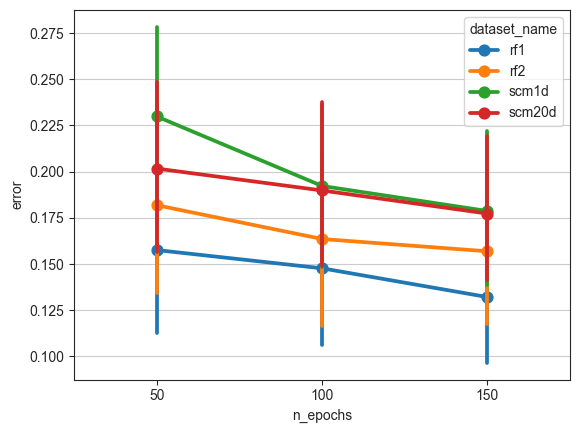

In [75]:
sns.pointplot(df_tuning, x="n_epochs", y="error", hue="dataset_name")